In [1]:
from pathlib import Path
from glob import glob
import warnings
import numpy as np
from sherpa.astro import ui
from sherpa.astro import datastack as ds
import sherpa

from astropy.io import fits
from astropy.table import Table
import astropy.units as u

import ChiantiPy.core as ch

 ChiantiPy version 0.11.0 
 found PyQt5 widgets
 using PyQt5 widgets


/nfs/melkor/d1/guenther/soft/anaconda/envs/ciao/lib/python3.8/site-packages/ChiantiPy/core/IpyMspectrum.py:9: UserWarning: ipyparallel not found. You won't be able to use the ipymspectrum module
  warnings.warn("ipyparallel not found. You won't be able to use the ipymspectrum module")


In [2]:
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
obsids = ['5', 'XMM', '6443', '7435', '7436', '7437', '7438', '13250',
          '23382', '23384', '23383', '23385', '23386', '24989']
dslist = {}

In [4]:
tgpart = ['dummy', 'heg', 'meg', 'leg']

def loadpha2(obsid):
    stack = ds.DataStack()
    dirname = glob(f'data/Chandra/tgcat/*_{obsid}*/')[0]
    pha2 = glob(dirname + '*pha2.*')
    ui.load_data(pha2[0])
    tab = Table.read(pha2[0], hdu=1, format='fits')
    # Use only 1 orders
    ind = np.abs(tab['TG_M']) == 1
    for row in tab[ind]:
        dataname = obsid + '_' + tgpart[row['TG_PART']] + '_' + str(row['TG_M'])
        ui.copy_data(row['SPEC_NUM'], dataname)
        m = row['TG_M']
        part = tgpart[row['TG_PART']]
        if ui.get_data().header['INSTRUME'] == 'ACIS':
            ui.load_arf(dataname, f'{dirname}{part}_{m}.arf.gz')
            ui.load_rmf(dataname, f'{dirname}{part}_{m}.rmf.gz') 
        else:  # HRC has no order-sorting
            sign = '' if m > 0 else '-'
            # It's faster to just load the top 3 orders and the later 
            # ones don't contribute much anyway.
            for num in [1,2,3]:
                ui.load_arf(dataname, f'{dirname}{part}_{sign}{num}.arf.gz', num)
                ui.load_rmf(dataname, f'{dirname}{part}_{sign}{num}.rmf.gz', num) 
        stack._add_dataset(dataname)
    # We copied all dataids to be used to new names, so delete the automatic read-in numbers
    for row in range(len(tab)):
        ui.delete_data(row + 1)
    return stack

In [6]:
# Load in order of obervations, such that dslist is sorted by time
# First Chandra
dslist['5'] = loadpha2('5')

# Then XMM
path = 'data/XMM/0112880201/pps/'
ui.load_data('XMM_R1', path + 'P0112880201R1S004SRSPEC1003.FTZ')
ui.load_data('XMM_R2', path + 'P0112880201R2S005SRSPEC1003.FTZ')
ui.load_rmf('XMM_R1', path + 'P0112880201R1S004RSPMAT1003.FTZ')
ui.load_rmf('XMM_R2', path + 'P0112880201R2S005RSPMAT1003.FTZ')
stack = ds.DataStack()
stack._add_dataset('XMM_R1')
stack._add_dataset('XMM_R2')
dslist['XMM'] = stack

# and then all the other Chandra
for o in obsids[2:]:
    dslist[o] = loadpha2(o)

statistical errors were found in file 'data/Chandra/tgcat/obs_5_tgid_4988/pha2.gz' 
but not used; to use them, re-read with use_errors=True
read background_up into a dataset from file data/Chandra/tgcat/obs_5_tgid_4988/pha2.gz
read background_down into a dataset from file data/Chandra/tgcat/obs_5_tgid_4988/pha2.gz
Multiple data sets have been input: 1-12
statistical errors were found in file 'data/XMM/0112880201/pps/P0112880201R1S004SRSPEC1003.FTZ' 
but not used; to use them, re-read with use_errors=True
statistical errors were found in file 'data/XMM/0112880201/pps/P0112880201R2S005SRSPEC1003.FTZ' 
but not used; to use them, re-read with use_errors=True
statistical errors were found in file 'data/Chandra/tgcat/obs_6443_tgid_2459/pha2.gz' 
but not used; to use them, re-read with use_errors=True
read background file data/Chandra/tgcat/obs_6443_tgid_2459/pha2_bg
read background_up into a dataset from file data/Chandra/tgcat/obs_6443_tgid_2459/pha2.gz
read background_down into a dataset f

In [7]:
# Some default settings
ui.set_analysis('wave')
ui.set_stat('cash')

In [8]:
def indep_lines_model(lines, prefix=''):
    our_model = ui.const1d(name=f'{prefix}_bkg')
    our_model.c0.min = 0  # Fit goes heywire if we ever get negative values in model with cstat or cash
    for i, l in enumerate(lines):
        line = ui.delta1d(name=f'{prefix}_{i}')
        line.pos = l
        line.pos.frozen = True
        line.ampl = 1e-4
        line.ampl.min = 0
        our_model = our_model + line
    return our_model


In [9]:
# the colors part is only needed for plot_fit etc. where more than one line is plotted
# per dataset
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def stack_plot(stack, func=ui.plot_data):
    for i, dataset in enumerate(stack.filter_datasets()):
        func(dataset['id'], overplot= i!= 0, color=colors[i])
        
    ax = plt.gca()
    ax.legend([dataset['id'].split('_', maxsplit=1)[1] for dataset in stack.filter_datasets()])
    return ax

In [10]:
# I have a feeling this could be made more generically
# but for now just have them as separate functions

def fit(wvl, xmm=['XMM_R2']):
    for obsid, ds in dslist.items():
        ds.group_counts(1)
        ds.ignore(None, wvl[0])
        ds.ignore(wvl[1], None)
        ds.notice(*wvl)
        ui.set_stat("chi2gehrels")
        ui.set_method("levmar")
        if obsid == 'XMM':
            ui.fit(*xmm)
            ui.set_stat("cash")
            ui.fit(*xmm)
        else:
            ds.fit() 
            ui.set_stat("cash")
            ds.fit()
            
def conf(wvl, xmm=['XMM_R2']):
    conf_res = {}
    for obsid, ds in dslist.items():
        ds.group_counts(1)        
        ds.ignore(None, wvl[0])
        ds.ignore(wvl[1], None)
        ds.notice(*wvl)
        if obsid == 'XMM':
            ui.conf(*xmm)
        else:
            ds.conf()
        conf_res[obsid] = ui.get_conf_results()
    return conf_res

def plot(wvl, xmm=['XMM_R2'], group_counts=5):
    # Ignore a lot of "plotted errors on valid in this statistic errors"
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for obsid, ds in dslist.items():
            plt.figure()
            ds.group_counts(group_counts)
            ui.ignore(None, wvl[0])
            ui.ignore(wvl[1], None)
            ui.notice(*wvl)
            if obsid == 'XMM':
                for i, x in enumerate(xmm):
                    ui.plot_fit(x, color=colors[i], overplot= i != 0)
                ax = plt.gca()
                ax.legend(xmm)
            else:
                ax = stack_plot(ds, func=ui.plot_fit)
            ax.set_title(obsid)
            ax.set_xlim(*wvl)

## Ne IX
### He-like triplet

In [11]:
for obsid, ds in dslist.items():
    ds.set_source(indep_lines_model([13.447, 13.553, 13.699], prefix=obsid))

In [12]:
fit([13.40, 13.75], ['XMM_R2'])

Datasets              = '5_heg_-1', '5_heg_1', '5_meg_-1', '5_meg_1'
Method                = levmar
Statistic             = chi2gehrels
Initial fit statistic = 8.04814e+08
Final fit statistic   = 112.677 at function evaluation 10
Data points           = 164
Degrees of freedom    = 160
Probability [Q-value] = 0.998278
Reduced statistic     = 0.704228
Change in statistic   = 8.04814e+08
   5_bkg.c0       8.8549e-05   +/- 3.64732e-05 
   5_0.ampl       0.000113581  +/- 1.22099e-05 
   5_1.ampl       9.42048e-05  +/- 1.16492e-05 
   5_2.ampl       4.42344e-05  +/- 9.84849e-06 
Datasets              = '5_heg_-1', '5_heg_1', '5_meg_-1', '5_meg_1'
Method                = levmar
Statistic             = cash
Initial fit statistic = -669.434
Final fit statistic   = -808.146 at function evaluation 21
Data points           = 164
Degrees of freedom    = 160
Change in statistic   = 138.712
   5_bkg.c0       0.000279763  +/- 2.90283e-05 
   5_0.ampl       0.000162915  +/- 1.10822e-05 
   5_1.ampl    

Datasets              = '7436_heg_-1', '7436_heg_1', '7436_meg_-1', '7436_meg_1'
Method                = levmar
Statistic             = cash
Initial fit statistic = -4525.42
Final fit statistic   = -4685.15 at function evaluation 21
Data points           = 209
Degrees of freedom    = 205
Change in statistic   = 159.728
   7436_bkg.c0    0.000198263  +/- 1.59593e-05 
   7436_0.ampl    0.000198026  +/- 8.12846e-06 
   7436_1.ampl    0.000120699  +/- 6.47161e-06 
   7436_2.ampl    5.64161e-05  +/- 4.35164e-06 
Datasets              = '7437_heg_-1', '7437_heg_1', '7437_meg_-1', '7437_meg_1'
Method                = levmar
Statistic             = chi2gehrels
Initial fit statistic = 2.26368e+09
Final fit statistic   = 133.703 at function evaluation 10
Data points           = 209
Degrees of freedom    = 205
Probability [Q-value] = 0.999969
Reduced statistic     = 0.652209
Change in statistic   = 2.26368e+09
   7437_bkg.c0    9.15265e-05  +/- 2.14825e-05 
   7437_0.ampl    0.000131724  +/- 8.13

Datasets              = '23384_leg_-1', '23384_leg_1'
Method                = levmar
Statistic             = chi2gehrels
Initial fit statistic = 8.03267e+07
Final fit statistic   = 22.8861 at function evaluation 10
Data points           = 56
Degrees of freedom    = 52
Probability [Q-value] = 0.999849
Reduced statistic     = 0.440118
Change in statistic   = 8.03267e+07
   23384_bkg.c0   0.000459406  +/- 0.000172404 
   23384_0.ampl   0.000220635  +/- 3.36911e-05 
   23384_1.ampl   0.000113417  +/- 2.97872e-05 
   23384_2.ampl   6.30708e-05  +/- 2.71571e-05 
Datasets              = '23384_leg_-1', '23384_leg_1'
Method                = levmar
Statistic             = cash
Initial fit statistic = -673.966
Final fit statistic   = -679.391 at function evaluation 21
Data points           = 56
Degrees of freedom    = 52
Change in statistic   = 5.42476
   23384_bkg.c0   0.000606838  +/- 0.000121798 
   23384_0.ampl   0.000216993  +/- 2.59226e-05 
   23384_1.ampl   0.000113558  +/- 2.19678e-05 
 

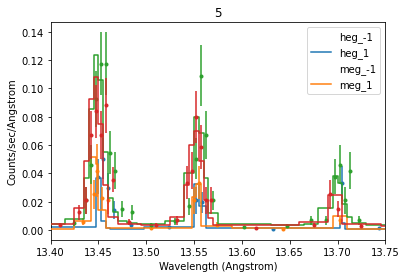

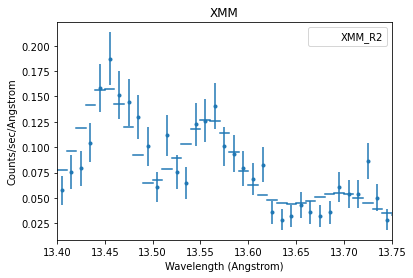

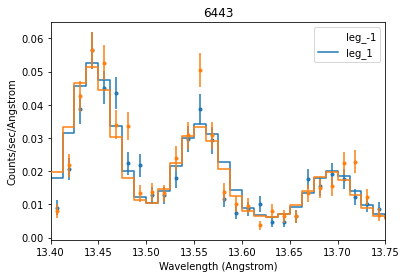

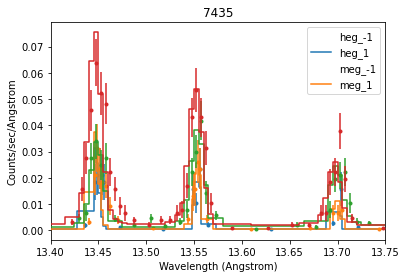

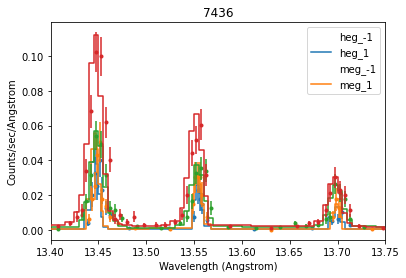

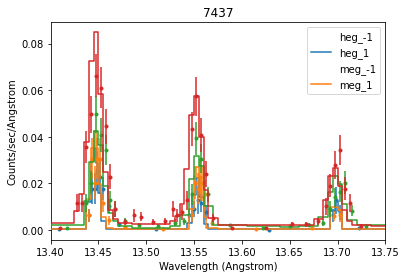

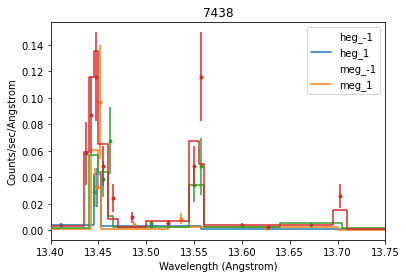

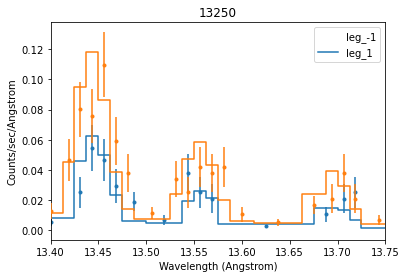

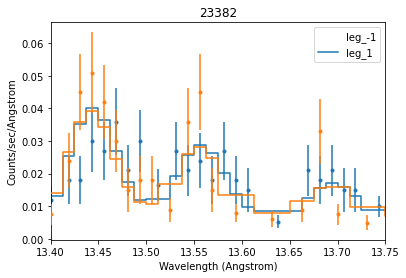

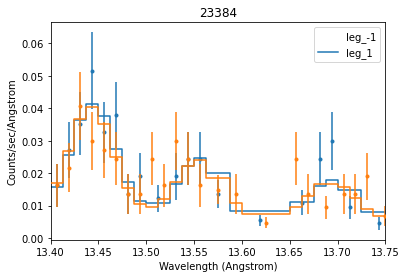

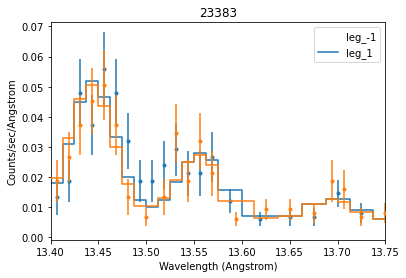

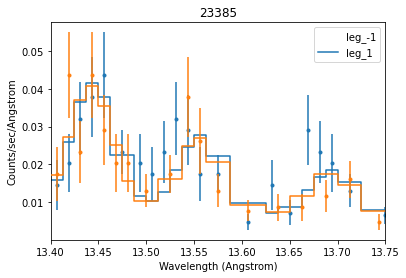

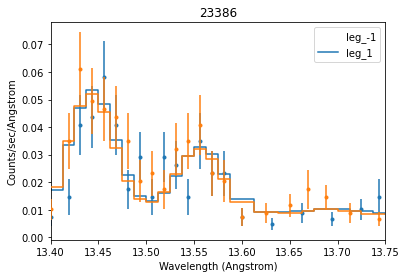

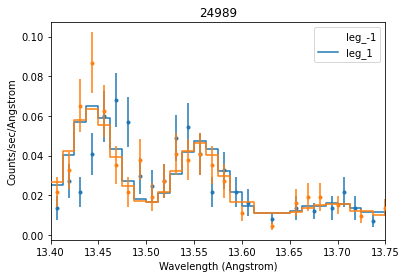

In [13]:
plot([13.40, 13.75], ['XMM_R2'])

In [14]:
conf_res = conf([13.40, 13.75], ['XMM_R2'])

5_bkg.c0 lower bound:	-2.81391e-05
5_0.ampl lower bound:	-1.09423e-05
5_1.ampl lower bound:	-8.8129e-06
5_2.ampl lower bound:	-6.76897e-06
5_bkg.c0 upper bound:	2.99545e-05
5_0.ampl upper bound:	1.12896e-05
5_1.ampl upper bound:	9.23592e-06
5_2.ampl upper bound:	7.31929e-06
Datasets              = '5_heg_-1', '5_heg_1', '5_meg_-1', '5_meg_1'
Confidence Method     = confidence
Iterative Fit Method  = None
Fitting Method        = levmar
Statistic             = cash
confidence 1-sigma (68.2689%) bounds:
   Param            Best-Fit  Lower Bound  Upper Bound
   -----            --------  -----------  -----------
   5_bkg.c0      0.000279763 -2.81391e-05  2.99545e-05
   5_0.ampl      0.000162915 -1.09423e-05  1.12896e-05
   5_1.ampl       0.00010639  -8.8129e-06  9.23592e-06
   5_2.ampl      5.08665e-05 -6.76897e-06  7.31929e-06
XMM_0.ampl lower bound:	-2.48301e-05
XMM_0.ampl upper bound:	2.48301e-05
XMM_bkg.c0 lower bound:	-0.000120162
XMM_2.ampl lower bound:	-2.10711e-05
XMM_1.ampl lower 

7438_1.ampl upper bound:	1.98936e-05
7438_2.ampl upper bound:	1.13957e-05
Datasets              = '7438_heg_-1', '7438_heg_1', '7438_meg_-1', '7438_meg_1'
Confidence Method     = confidence
Iterative Fit Method  = None
Fitting Method        = levmar
Statistic             = cash
confidence 1-sigma (68.2689%) bounds:
   Param            Best-Fit  Lower Bound  Upper Bound
   -----            --------  -----------  -----------
   7438_bkg.c0   0.000113007 -2.65675e-05  3.01098e-05
   7438_0.ampl   0.000241632 -2.39956e-05  2.55437e-05
   7438_1.ampl   0.000134157 -1.81121e-05  1.98936e-05
   7438_2.ampl   4.30879e-05 -9.82676e-06  1.13957e-05
13250_bkg.c0 lower bound:	-3.94547e-05
13250_1.ampl lower bound:	-1.48236e-05
13250_bkg.c0 upper bound:	4.47154e-05
13250_0.ampl lower bound:	-2.19963e-05
13250_2.ampl lower bound:	-1.26829e-05
13250_1.ampl upper bound:	1.578e-05
13250_2.ampl upper bound:	1.38172e-05
13250_0.ampl upper bound:	2.30521e-05
Datasets              = '13250_leg_-1', '13250_

In [15]:
farr = np.stack([np.array([c.parvals, c.parmins, c.parmaxes], 
                          dtype=np.floating) for c in conf_res.values()])

### He $\beta$

In [16]:
for obsid, ds in dslist.items():
    ds.set_source(indep_lines_model([11.5467], prefix=obsid))

In [17]:
fit([11.45, 11.65], ['XMM_R2'])

Datasets              = '5_heg_-1', '5_heg_1', '5_meg_-1', '5_meg_1'
Method                = levmar
Statistic             = chi2gehrels
Initial fit statistic = 503.977
Final fit statistic   = 9.89514 at function evaluation 6
Data points           = 67
Degrees of freedom    = 65
Probability [Q-value] = 1
Reduced statistic     = 0.152233
Change in statistic   = 494.082
   5_bkg.c0       4.9587e-05   +/- 2.21486e-05 
   5_0.ampl       2.06773e-05  +/- 4.62761e-06 
Datasets              = '5_heg_-1', '5_heg_1', '5_meg_-1', '5_meg_1'
Method                = levmar
Statistic             = cash
Initial fit statistic = 93.9457
Final fit statistic   = 78.3405 at function evaluation 13
Data points           = 67
Degrees of freedom    = 65
Change in statistic   = 15.6052
   5_bkg.c0       9.08767e-05  +/- 1.3336e-05  
   5_0.ampl       2.19525e-05  +/- 3.06509e-06 
Dataset               = XMM_R2
Method                = levmar
Statistic             = chi2gehrels
Initial fit statistic = 189.103
Fin

Datasets              = '7437_heg_-1', '7437_heg_1', '7437_meg_-1', '7437_meg_1'
Method                = levmar
Statistic             = chi2gehrels
Initial fit statistic = 1485.47
Final fit statistic   = 36.2571 at function evaluation 6
Data points           = 96
Degrees of freedom    = 94
Probability [Q-value] = 1
Reduced statistic     = 0.385714
Change in statistic   = 1449.21
   7437_bkg.c0    3.93815e-05  +/- 1.09692e-05 
   7437_0.ampl    2.17206e-05  +/- 2.42876e-06 
Datasets              = '7437_heg_-1', '7437_heg_1', '7437_meg_-1', '7437_meg_1'
Method                = levmar
Statistic             = cash
Initial fit statistic = -302.901
Final fit statistic   = -336.129 at function evaluation 13
Data points           = 96
Degrees of freedom    = 94
Change in statistic   = 33.2283
   7437_bkg.c0    7.13397e-05  +/- 7.39596e-06 
   7437_0.ampl    2.44107e-05  +/- 1.9116e-06  
Datasets              = '7438_heg_-1', '7438_heg_1', '7438_meg_-1', '7438_meg_1'
Method                = le

Datasets              = '23383_leg_-1', '23383_leg_1'
Method                = levmar
Statistic             = cash
Initial fit statistic = -9.31248
Final fit statistic   = -12.9305 at function evaluation 13
Data points           = 31
Degrees of freedom    = 29
Change in statistic   = 3.61799
   23383_bkg.c0   0.000554869  +/- 9.08523e-05 
   23383_0.ampl   3.37474e-05  +/- 1.53776e-05 
Datasets              = '23385_leg_-1', '23385_leg_1'
Method                = levmar
Statistic             = chi2gehrels
Initial fit statistic = 50.7102
Final fit statistic   = 5.71604 at function evaluation 6
Data points           = 29
Degrees of freedom    = 27
Probability [Q-value] = 0.999996
Reduced statistic     = 0.211705
Change in statistic   = 44.9941
   23385_bkg.c0   0.000199795  +/- 0.000121525 
   23385_0.ampl   3.614e-05    +/- 2.31815e-05 
Datasets              = '23385_leg_-1', '23385_leg_1'
Method                = levmar
Statistic             = cash
Initial fit statistic = 51.6001
Final fi

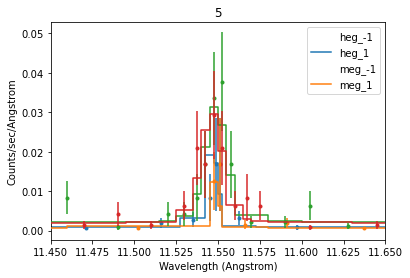

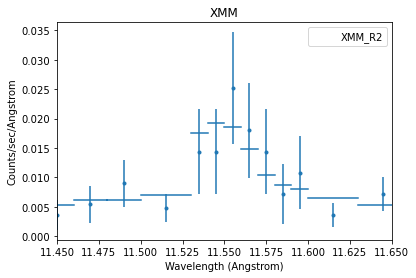

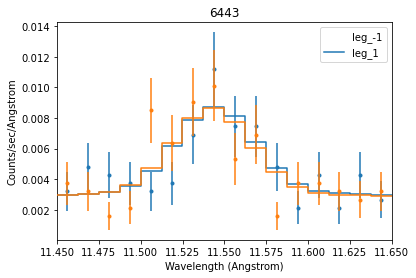

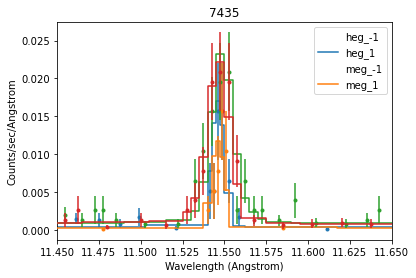

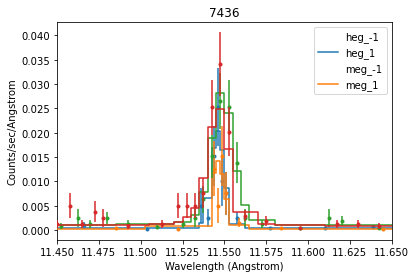

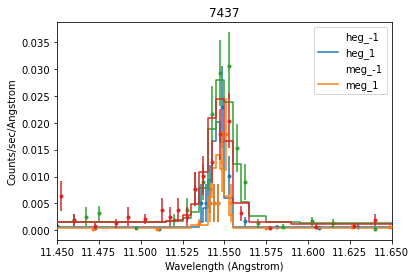

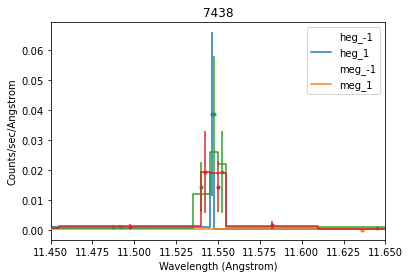

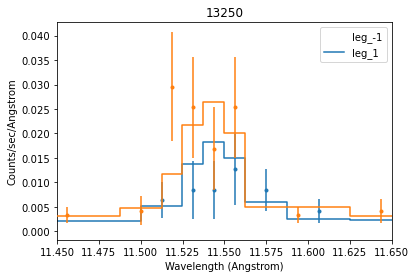

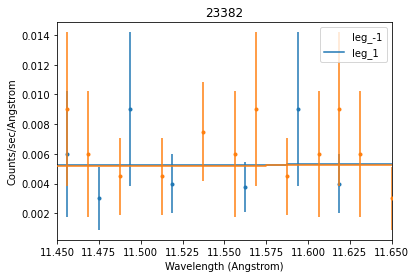

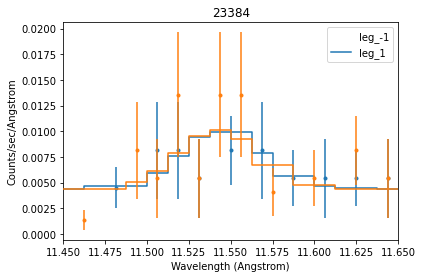

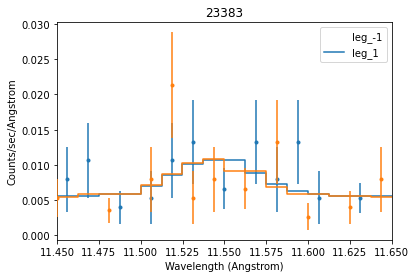

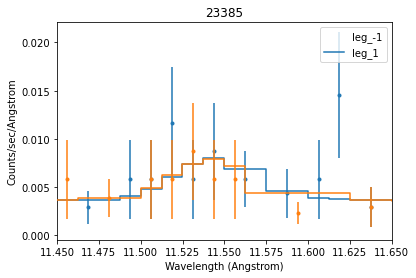

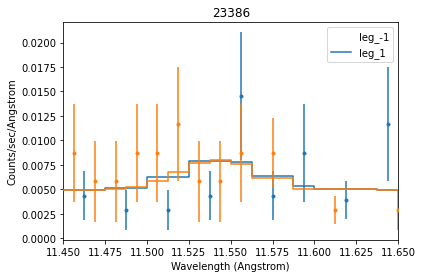

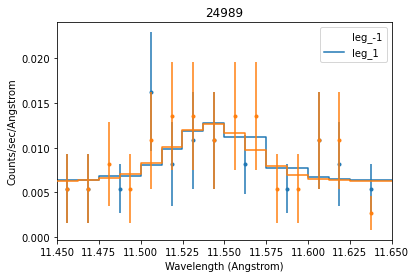

In [18]:
plot([11.45, 11.65], ['XMM_R2'], group_counts=2)

In [19]:
conf_res_hea = conf([11.4, 11.7], ['XMM_R2'])

5_0.ampl lower bound:	-3.1873e-06
5_bkg.c0 lower bound:	-7.52469e-06
5_0.ampl upper bound:	3.14904e-06
5_bkg.c0 upper bound:	1.48876e-05
Datasets              = '5_heg_-1', '5_heg_1', '5_meg_-1', '5_meg_1'
Confidence Method     = confidence
Iterative Fit Method  = None
Fitting Method        = levmar
Statistic             = cash
confidence 1-sigma (68.2689%) bounds:
   Param            Best-Fit  Lower Bound  Upper Bound
   -----            --------  -----------  -----------
   5_bkg.c0      9.08767e-05 -7.52469e-06  1.48876e-05
   5_0.ampl      2.19525e-05  -3.1873e-06  3.14904e-06
Method                = levmar
Statistic             = cash
Initial fit statistic = -14.2207
Final fit statistic   = -15.2528 at function evaluation 10
Data points           = 23
Degrees of freedom    = 21
Change in statistic   = 1.03214
   XMM_bkg.c0     7.69922e-05  +/- 2.2722e-05  
   XMM_0.ampl     2.83664e-05  +/- 8.92338e-06 
XMM_bkg.c0 lower bound:	-2.10487e-05
XMM_0.ampl lower bound:	-8.37566e-06
XMM_

13250_bkg.c0 upper bound:	1.76541e-05
13250_0.ampl lower bound:	-7.41053e-06
13250_0.ampl upper bound:	1.01814e-05
Datasets              = '13250_leg_-1', '13250_leg_1'
Confidence Method     = confidence
Iterative Fit Method  = None
Fitting Method        = levmar
Statistic             = cash
confidence 1-sigma (68.2689%) bounds:
   Param            Best-Fit  Lower Bound  Upper Bound
   -----            --------  -----------  -----------
   13250_bkg.c0  0.000114013  -3.2007e-05  1.76541e-05
   13250_0.ampl  3.98003e-05 -7.41053e-06  1.01814e-05
23382_0.ampl lower bound:	-6.47957e-06
23382_0.ampl upper bound:	2.64625e-05
23382_bkg.c0 lower bound:	-9.83937e-05
23382_bkg.c0 upper bound:	3.08943e-05
Datasets              = '23382_leg_-1', '23382_leg_1'
Confidence Method     = confidence
Iterative Fit Method  = None
Fitting Method        = levmar
Statistic             = cash
confidence 1-sigma (68.2689%) bounds:
   Param            Best-Fit  Lower Bound  Upper Bound
   -----            ----

In [33]:
farr2 = np.stack([np.array([c.parvals, c.parmins, c.parmaxes], 
                          dtype=np.floating) for c in conf_res_hea.values()])

In [21]:
alpha2beta = farr[:, 0, 1] / farr2[:, 0, 1]
sig_alpha2beta = np.sqrt((farr[:, 2, 1] / farr2[:, 0, 1])**2 + (farr[:, 0, 1] * farr2[:, 2, 1] / farr2[:, 0, 1]**2)**2)

<ErrorbarContainer object of 3 artists>

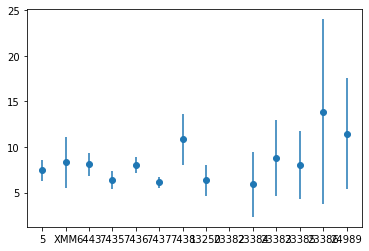

In [34]:
plt.errorbar(obsids, alpha2beta, yerr=sig_alpha2beta, fmt='o')

In [23]:
f2i = farr[:, 0, 3] / farr[:, 0, 2]
sig_f2i = np.sqrt((farr[:, 2, 3] / farr[:, 0, 2])**2 + (farr[:, 0, 3] * farr[:, 2, 2] / farr[:, 0, 2]**2)**2)

In [24]:
fi2r = (farr[:, 0, 3] + farr[:, 0, 2]) / farr[:, 0, 1]
sig_fi2r = np.sqrt((farr[:, 2, 3] / farr[:, 0, 1])**2 + 
                   (farr[:, 2, 2] / farr[:, 0, 1])**2 + 
                   ((farr[:, 0, 3] + farr[:, 0, 2]) * farr[:, 2, 1] / farr[:, 0, 1]**2)**2)

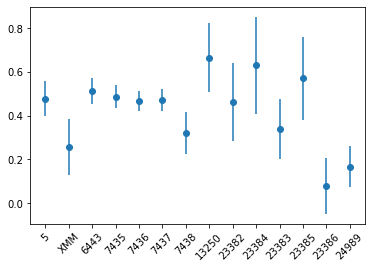

In [36]:
fig, ax = plt.subplots()
ax.errorbar(obsids, f2i, yerr=sig_f2i, fmt='o')
ax.xaxis.set_tick_params(rotation=45)

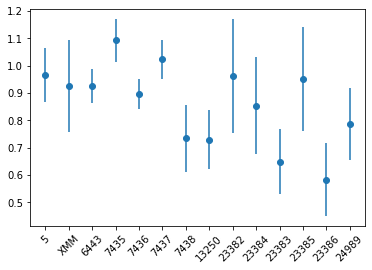

In [37]:
fig, ax = plt.subplots()
ax.errorbar(obsids, fi2r, yerr=sig_fi2r, fmt='o')
ax.xaxis.set_tick_params(rotation=45)

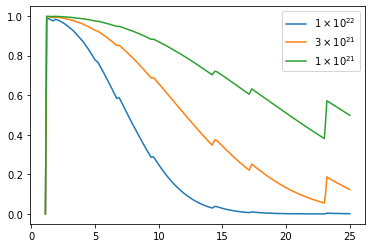

In [27]:
phabs = ui.xsphabs("phabs")
phabs.nH = 1
lam = np.arange(25., 1., -.1)
en = 12.4/lam
phabs.nH = 1
plt.plot(lam, phabs(en), label='$1 \\times 10^{22}$')
phabs.nH = .3
plt.plot(lam, phabs(en), label='$3\\times 10^{21}$')
phabs.nH = .1
plt.plot(lam, phabs(en), label='$1 \\times 10^{21}$')

plt.legend()

In [28]:
logtemp = np.arange(6.1, 7.01, .1)
temp = 10**logtemp
ne9 = ch.ion('ne_9', temperature=temp, eDensity=1.e+9, em=1.e+27)
ne9.intensity()

In [44]:
def lineemiss(ion, lvl1, lvl2):
    ind = (ion.Emiss[lvl1[0]] == lvl1[1]) & (ion.Emiss[lvl2[0]] == lvl2[1])
    # Do I want an assert statement here ot see that I selected the right lines?
    
    assert ind.sum() == 1
    return ion.Emiss['emiss'][ind].flatten()

In [60]:
e_heb = lineemiss(ne9, ('lvl1', 1), ('pretty2', '1s.3p 1P1.0'))
e_hea = lineemiss(ne9, ('lvl1', 1), ('pretty2', '1s.2p 1P1.0'))
e_i1 = lineemiss(ne9, ('lvl1', 1), ('pretty2', '1s.2p 3P2.0'))
e_i2 = lineemiss(ne9, ('lvl1', 1), ('pretty2', '1s.2p 3P1.0'))
e_f = lineemiss(ne9, ('lvl1', 1), ('pretty2', '1s.2s 3S1.0'))

Text(0, 0.5, 'ratio Ly$\\alpha$/Ly$\\beta$')

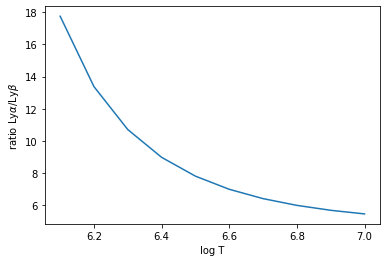

In [61]:
plt.plot(logtemp, e_hea / e_heb)
plt.xlabel('log T')
plt.ylabel('ratio Ly$\\alpha$/Ly$\\beta$')

Text(0, 0.5, 'ratio (f+i)/r')

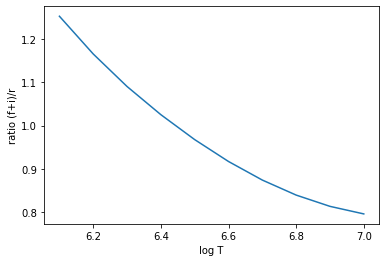

In [62]:
plt.plot(logtemp, (e_i1 + e_i2 + e_f) / e_hea)
plt.xlabel('log T')
plt.ylabel('ratio (f+i)/r')

In [63]:
xp = (e_i1 + e_i2 + e_f) / e_hea
sortind = np.argsort(xp)
xp = xp[sortind]
fp = logtemp[sortind]
t_from_g = np.interp(fi2r, xp, fp)
t_from_g_up = np.interp(fi2r + sig_fi2r, xp, fp) - t_from_g
t_from_g_do = np.interp(fi2r - sig_fi2r, xp, fp) - t_from_g

In [64]:
phabs = ui.xsphabs("phabs")
phabs.nH = .1

In [65]:
# Input is "edge of bins", return values are for bin center.
# So need to make a few narrow bins around the range I care.
absval = phabs(([13.46, 13.45, 13.44, 11.56, 11.55, 11.54, 5.]
                * u.Angstrom).to(u.keV, equivalencies=u.spectral()).value)
absval

array([0.7334957, 0.7339343, 0.7721647, 0.8123384, 0.8127275, 0.8900622,
       0.       ], dtype=float32)

In [66]:
abscoeffalpha = - 1e-21 * np.log(absval[2])
abscoeffbeta = - 1e-21 * np.log(absval[4])
abscoeffalpha, abscoeffbeta

(2.5855740904808043e-22, 2.073593884706497e-22)

In [67]:
Gratio, Habobs = np.mgrid[.3:1.4:.01, 3:14:.01]

In [68]:
logT_from_G = np.interp(Gratio, xp, fp)
Hab_from_logT = np.interp(logT_from_G, logtemp, e_hea / e_heb)

N_H = np.log(Habobs/Hab_from_logT) / (abscoeffbeta - abscoeffalpha) / 1e21

In [70]:
print(plt.rcParams['axes.prop_cycle'].by_key()['color'])

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


In [73]:
obsids

['5',
 'XMM',
 '6443',
 '7435',
 '7436',
 '7437',
 '7438',
 '13250',
 '23382',
 '23384',
 '23383',
 '23385',
 '23386',
 '24989']

/nfs/melkor/d1/guenther/soft/anaconda/envs/ciao/lib/python3.8/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/nfs/melkor/d1/guenther/soft/anaconda/envs/ciao/lib/python3.8/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/nfs/melkor/d1/guenther/soft/anaconda/envs/ciao/lib/python3.8/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/nfs/melkor/d1/guenther/soft/anaconda/envs/ciao/lib/python3.8/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/nfs/melkor/d1/guenther/soft/anaconda/envs/ciao/lib/python3.8/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked elemen

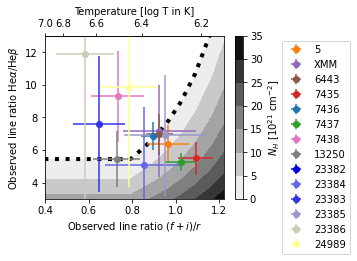

In [77]:
# Define colors so that they match figure 3 in Brickhouse et al. (2012)
# Other colors are taken from default matplotlib color cycle
obscolors = {'5': '#ff7f0e', 
             'XMM': '#9467bd',
             '6443': '#8c564b', 
             '7435': '#d62728',
             '7436': '#1f77b4', 
             '7437': '#2ca02c',
             '7438': '#e377c2',
             '13250': '#7f7f7f',
             '23382': (.0, .0, .9),
             '23383': (.2, .2, .9),
             '23384': (.4, .4, .9),
             '23385': (.6, .6, .8),
             '23386': (.8, .8, .7),
             '24989': (1, 1., .6),}

def grat2logt(g):
    return np.interp(g, xp, fp)

def logt2grat(logt):
    return np.interp(logt, fp[::-1], xp[::-1])

fig, ax = plt.subplots(figsize=(4,3))
cs = ax.contourf(Gratio, Habobs, np.ma.masked_less_equal(N_H, 0), cmap='binary')
cslines = ax.contour(Gratio, Habobs, N_H, levels=[0], linestyles=['dotted'], colors=['k'], linewidths=[4])
#ax.clabel(cs, cs.levels, inline=True, fontsize=10)
cb = fig.colorbar(cs, ax=ax)
for i, o in enumerate(obsids):
    eb = ax.errorbar(fi2r[i], alpha2beta[i] * 11.55 / 13.45, xerr=sig_fi2r[i], yerr=sig_alpha2beta[i],
                     fmt='o', label=o, color=obscolors[o])

secax = ax.secondary_xaxis('top', functions=(grat2logt, logt2grat))
secax.set_xlabel('Temperature [log T in K]')
    
ax.set_xlim(.4, 1.22)
ax.set_ylim(3, 13)
cb.set_label('$N_H$ [$10^{21}$ cm$^{-2}$]')
ax.set_xlabel('Observed line ratio $(f+i)/r$')
ax.set_ylabel('Observed line ratio He$\\alpha$/He$\\beta$')
ax.legend(loc='upper left', bbox_to_anchor=(1.3, 1))

fig.savefig('../plots/Ne-var.png', bbox_inches='tight', dpi=300)

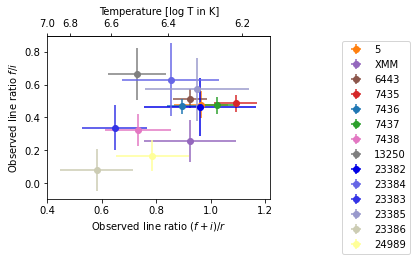

In [78]:
fig, ax = plt.subplots(figsize=(4,3))

for i, o in enumerate(obsids):
    eb = ax.errorbar(fi2r[i], f2i[i], xerr=sig_fi2r[i], yerr=sig_f2i[i],
                     fmt='o', label=o, color=obscolors[o])

secax = ax.secondary_xaxis('top', functions=(grat2logt, logt2grat))
secax.set_xlabel('Temperature [log T in K]')
    
ax.set_xlim(.4, 1.22)
#ax.set_ylim(3, 13)
ax.set_xlabel('Observed line ratio $(f+i)/r$')
ax.set_ylabel('Observed line ratio $f/i$')
ax.legend(loc='upper left', bbox_to_anchor=(1.3, 1))

fig.savefig('../plots/Ne-var2.png', bbox_inches='tight', dpi=300)

## O VII

In [79]:
for obsid, ds in dslist.items():
    ds.set_source(indep_lines_model([21.602, 21.804, 22.101], prefix=obsid))

In [80]:
fit([21.4, 22.3], ['XMM_R1'])
conf_res = conf([21.4, 22.3], ['XMM_R1'])

Datasets              = '5_heg_-1', '5_heg_1', '5_meg_-1', '5_meg_1'
Method                = levmar
Statistic             = chi2gehrels
Initial fit statistic = 31.799
Final fit statistic   = 12.0916 at function evaluation 10
Data points           = 39
Degrees of freedom    = 35
Probability [Q-value] = 0.99989
Reduced statistic     = 0.345473
Change in statistic   = 19.7075
   5_bkg.c0       5.46855e-05  +/- 3.86324e-05 
   5_0.ampl       8.56233e-05  +/- 3.75984e-05 
   5_1.ampl       7.04812e-05  +/- 3.51913e-05 
   5_2.ampl       9.37763e-06  +/- 2.28446e-05 
Datasets              = '5_heg_-1', '5_heg_1', '5_meg_-1', '5_meg_1'
Method                = levmar
Statistic             = cash
Initial fit statistic = 84.5005
Final fit statistic   = 66.7983 at function evaluation 21
Data points           = 39
Degrees of freedom    = 35
Change in statistic   = 17.7021
   5_bkg.c0       9.59758e-05  +/- 2.43461e-05 
   5_0.ampl       0.000136313  +/- 2.7359e-05  
   5_1.ampl       0.000126947  

Datasets              = '7436_heg_-1', '7436_heg_1', '7436_meg_-1', '7436_meg_1'
Method                = levmar
Statistic             = cash
Initial fit statistic = 80.8548
Final fit statistic   = 66.3373 at function evaluation 21
Data points           = 61
Degrees of freedom    = 57
Change in statistic   = 14.5175
   7436_bkg.c0    0.000126885  +/- 2.40014e-05 
   7436_0.ampl    0.000118929  +/- 1.937e-05   
   7436_1.ampl    9.19113e-05  +/- 1.81018e-05 
   7436_2.ampl    2.93085e-06  +/- 6.54216e-06 
Datasets              = '7437_heg_-1', '7437_heg_1', '7437_meg_-1', '7437_meg_1'
Method                = levmar
Statistic             = chi2gehrels
Initial fit statistic = 33.8193
Final fit statistic   = 11.8314 at function evaluation 10
Data points           = 51
Degrees of freedom    = 47
Probability [Q-value] = 1
Reduced statistic     = 0.251732
Change in statistic   = 21.9878
   7437_bkg.c0    6.22561e-05  +/- 4.00182e-05 
   7437_0.ampl    0.000115603  +/- 2.93461e-05 
   7437_1.am

Datasets              = '23384_leg_-1', '23384_leg_1'
Method                = levmar
Statistic             = chi2gehrels
Initial fit statistic = 42.7586
Final fit statistic   = 35.4159 at function evaluation 10
Data points           = 125
Degrees of freedom    = 121
Probability [Q-value] = 1
Reduced statistic     = 0.292694
Change in statistic   = 7.34271
   23384_bkg.c0   0.000503173  +/- 8.81889e-05 
   23384_0.ampl   0.000113228  +/- 3.74478e-05 
   23384_1.ampl   0.000104165  +/- 3.681e-05   
   23384_2.ampl   2.02494e-05  +/- 3.0288e-05  
Datasets              = '23384_leg_-1', '23384_leg_1'
Method                = levmar
Statistic             = cash
Initial fit statistic = 51.5066
Final fit statistic   = 29.5383 at function evaluation 21
Data points           = 125
Degrees of freedom    = 121
Change in statistic   = 21.9683
   23384_bkg.c0   0.000713821  +/- 5.6251e-05  
   23384_0.ampl   0.00012029   +/- 2.58135e-05 
   23384_1.ampl   0.000111802  +/- 2.55953e-05 
   23384_2.amp

5_0.ampl lower bound:	-2.55041e-05
5_bkg.c0 lower bound:	-2.21912e-05
5_1.ampl lower bound:	-2.56708e-05
5_2.ampl lower bound:	-8.07772e-06
5_0.ampl upper bound:	2.89046e-05
5_1.ampl upper bound:	2.9338e-05
5_bkg.c0 upper bound:	2.58897e-05
5_2.ampl upper bound:	1.22953e-05
Datasets              = '5_heg_-1', '5_heg_1', '5_meg_-1', '5_meg_1'
Confidence Method     = confidence
Iterative Fit Method  = None
Fitting Method        = levmar
Statistic             = cash
confidence 1-sigma (68.2689%) bounds:
   Param            Best-Fit  Lower Bound  Upper Bound
   -----            --------  -----------  -----------
   5_bkg.c0      9.59758e-05 -2.21912e-05  2.58897e-05
   5_0.ampl      0.000136313 -2.55041e-05  2.89046e-05
   5_1.ampl      0.000126947 -2.56708e-05   2.9338e-05
   5_2.ampl      5.92957e-06 -8.07772e-06  1.22953e-05
XMM_2.ampl lower bound:	-2.41773e-06
XMM_2.ampl upper bound:	1.11709e-05
XMM_1.ampl lower bound:	-1.33765e-05
XMM_bkg.c0 lower bound:	-1.80143e-05
XMM_1.ampl upper 

13250_2.ampl -: WARNING: The confidence level lies within (-2.241902e-05, -2.161834e-05)
13250_2.ampl lower bound:	-2.20187e-05
13250_bkg.c0 lower bound:	-4.8073e-05
13250_2.ampl upper bound:	8.80747e-06
13250_bkg.c0 upper bound:	2.73126e-05
13250_1.ampl lower bound:	-2.208e-05
13250_0.ampl lower bound:	-2.37426e-05
13250_1.ampl upper bound:	3.16007e-05
13250_0.ampl upper bound:	3.10965e-05
Datasets              = '13250_leg_-1', '13250_leg_1'
Confidence Method     = confidence
Iterative Fit Method  = None
Fitting Method        = levmar
Statistic             = cash
confidence 1-sigma (68.2689%) bounds:
   Param            Best-Fit  Lower Bound  Upper Bound
   -----            --------  -----------  -----------
   13250_bkg.c0   0.00016439  -4.8073e-05  2.73126e-05
   13250_0.ampl  9.33035e-05 -2.37426e-05  3.10965e-05
   13250_1.ampl  7.99753e-05   -2.208e-05  3.16007e-05
   13250_2.ampl            0 -2.20187e-05  8.80747e-06
23382_2.ampl lower bound:	-1.73228e-05
23382_0.ampl lower bo

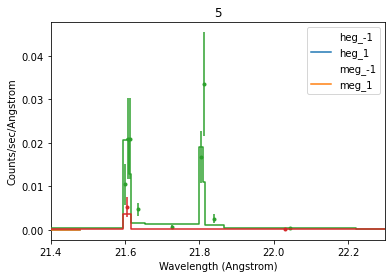

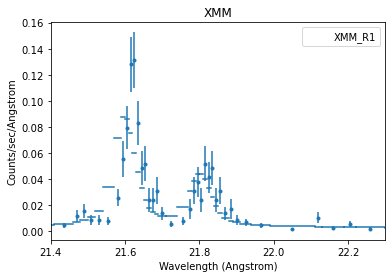

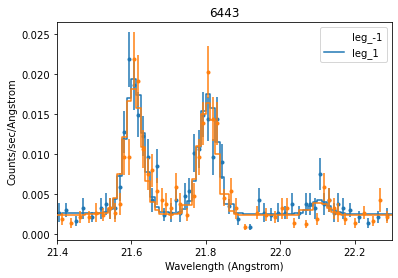

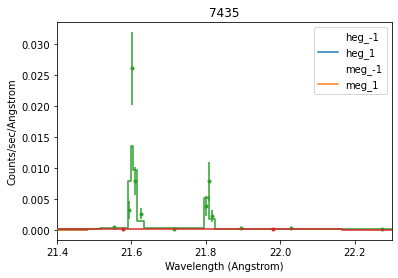

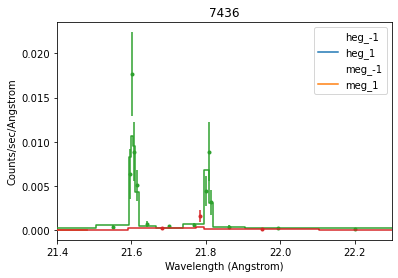

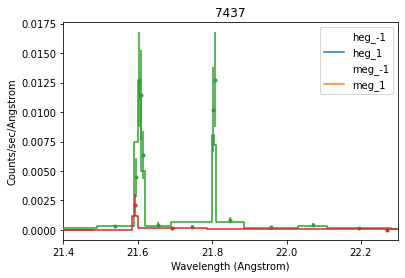

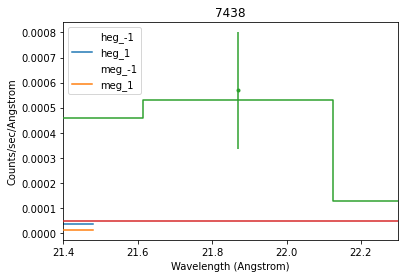

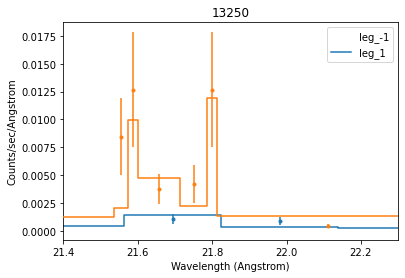

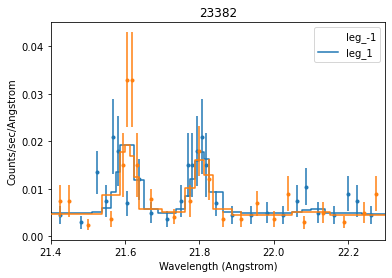

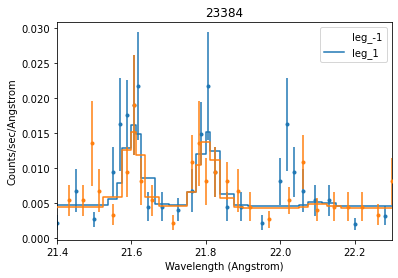

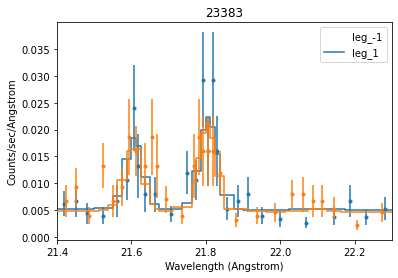

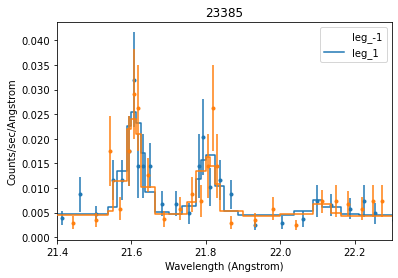

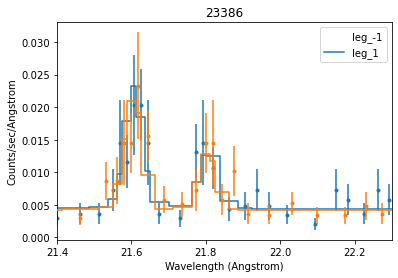

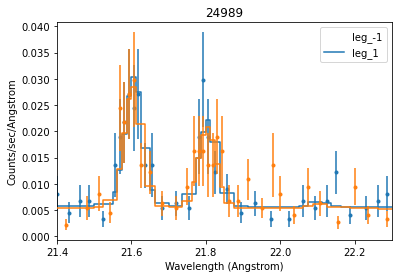

In [81]:
plot([21.4, 22.3], ['XMM_R1'])

In [82]:
farr = np.stack([np.array([c.parvals, c.parmins, c.parmaxes], 
                          dtype=np.floating) for c in conf_res.values()])

### He b

In [83]:
for obsid, ds in dslist.items():
    ds.set_source(indep_lines_model([18.627], prefix=obsid))

In [84]:
fit([18.45, 18.80], ['XMM_R1'])
conf_res_heb = conf([18.45, 18.80], ['XMM_R1'])

Datasets              = '5_heg_-1', '5_heg_1', '5_meg_-1', '5_meg_1'
Method                = levmar
Statistic             = chi2gehrels
Initial fit statistic = 36.0567
Final fit statistic   = 2.38224 at function evaluation 6
Data points           = 24
Degrees of freedom    = 22
Probability [Q-value] = 1
Reduced statistic     = 0.108284
Change in statistic   = 33.6744
   5_bkg.c0       4.32074e-05  +/- 3.24126e-05 
   5_0.ampl       2.11252e-05  +/- 1.50342e-05 
Datasets              = '5_heg_-1', '5_heg_1', '5_meg_-1', '5_meg_1'
Method                = levmar
Statistic             = cash
Initial fit statistic = 63.2589
Final fit statistic   = 59.7031 at function evaluation 13
Data points           = 24
Degrees of freedom    = 22
Change in statistic   = 3.55586
   5_bkg.c0       6.52857e-05  +/- 1.77813e-05 
   5_0.ampl       2.8568e-05   +/- 8.86555e-06 
Dataset               = XMM_R1
Method                = levmar
Statistic             = chi2gehrels
Initial fit statistic = 109.628
Fin

Datasets              = '7437_heg_-1', '7437_heg_1', '7437_meg_-1', '7437_meg_1'
Method                = levmar
Statistic             = chi2gehrels
Initial fit statistic = 128.449
Final fit statistic   = 5.84613 at function evaluation 6
Data points           = 35
Degrees of freedom    = 33
Probability [Q-value] = 1
Reduced statistic     = 0.177155
Change in statistic   = 122.603
   7437_bkg.c0    2.69279e-05  +/- 1.98602e-05 
   7437_0.ampl    1.63991e-05  +/- 8.68442e-06 
Datasets              = '7437_heg_-1', '7437_heg_1', '7437_meg_-1', '7437_meg_1'
Method                = levmar
Statistic             = cash
Initial fit statistic = 104.698
Final fit statistic   = 86.798 at function evaluation 13
Data points           = 35
Degrees of freedom    = 33
Change in statistic   = 17.9004
   7437_bkg.c0    6.75238e-05  +/- 1.37742e-05 
   7437_0.ampl    1.999e-05    +/- 5.28322e-06 
Datasets              = '7438_heg_-1', '7438_heg_1', '7438_meg_-1', '7438_meg_1'
Method                = levma

Datasets              = '23383_leg_-1', '23383_leg_1'
Method                = levmar
Statistic             = cash
Initial fit statistic = 46.1594
Final fit statistic   = 40.7886 at function evaluation 13
Data points           = 52
Degrees of freedom    = 50
Change in statistic   = 5.37085
   23383_bkg.c0   0.000538239  +/- 5.98534e-05 
   23383_0.ampl   2.59329e-05  +/- 1.39041e-05 
Datasets              = '23385_leg_-1', '23385_leg_1'
Method                = levmar
Statistic             = chi2gehrels
Initial fit statistic = 57.882
Final fit statistic   = 13.5854 at function evaluation 6
Data points           = 49
Degrees of freedom    = 47
Probability [Q-value] = 1
Reduced statistic     = 0.28905
Change in statistic   = 44.2966
   23385_bkg.c0   0.000418799  +/- 0.000109325 
   23385_0.ampl   9.62006e-06  +/- 2.5423e-05  
Datasets              = '23385_leg_-1', '23385_leg_1'
Method                = levmar
Statistic             = cash
Initial fit statistic = 57.037
Final fit statistic 

7436_bkg.c0 lower bound:	-1.63225e-05
7436_0.ampl lower bound:	-5.58679e-06
7436_bkg.c0 upper bound:	1.84988e-05
7436_0.ampl upper bound:	6.33169e-06
Datasets              = '7436_heg_-1', '7436_heg_1', '7436_meg_-1', '7436_meg_1'
Confidence Method     = confidence
Iterative Fit Method  = None
Fitting Method        = levmar
Statistic             = cash
confidence 1-sigma (68.2689%) bounds:
   Param            Best-Fit  Lower Bound  Upper Bound
   -----            --------  -----------  -----------
   7436_bkg.c0   9.37572e-05 -1.63225e-05  1.84988e-05
   7436_0.ampl   2.68434e-05 -5.58679e-06  6.33169e-06
7437_bkg.c0 lower bound:	-1.2475e-05
7437_0.ampl lower bound:	-4.80172e-06
7437_bkg.c0 upper bound:	1.41383e-05
7437_0.ampl upper bound:	5.56839e-06
Datasets              = '7437_heg_-1', '7437_heg_1', '7437_meg_-1', '7437_meg_1'
Confidence Method     = confidence
Iterative Fit Method  = None
Fitting Method        = levmar
Statistic             = cash
confidence 1-sigma (68.2689%) bou

24989_bkg.c0 lower bound:	-6.1139e-05
24989_0.ampl lower bound:	-1.37651e-05
24989_bkg.c0 upper bound:	6.50835e-05
24989_0.ampl upper bound:	1.51191e-05
Datasets              = '24989_leg_-1', '24989_leg_1'
Confidence Method     = confidence
Iterative Fit Method  = None
Fitting Method        = levmar
Statistic             = cash
confidence 1-sigma (68.2689%) bounds:
   Param            Best-Fit  Lower Bound  Upper Bound
   -----            --------  -----------  -----------
   24989_bkg.c0  0.000607464  -6.1139e-05  6.50835e-05
   24989_0.ampl  2.14047e-05 -1.37651e-05  1.51191e-05


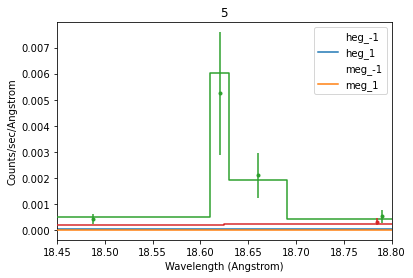

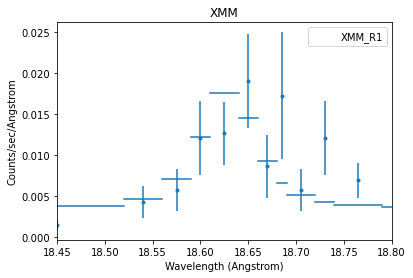

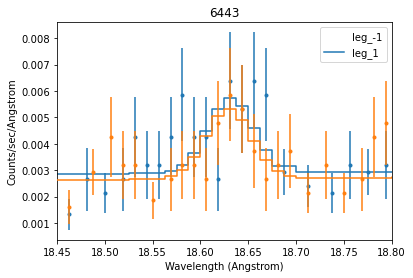

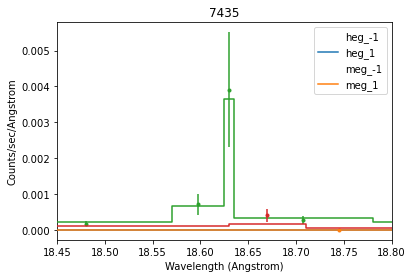

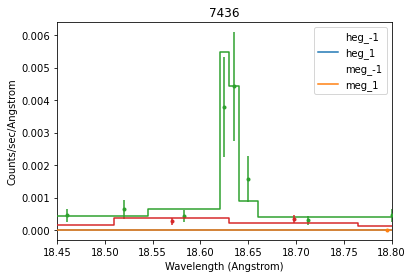

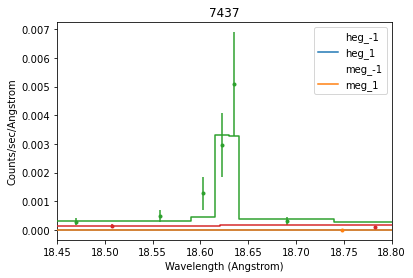

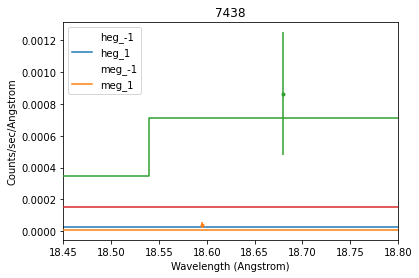

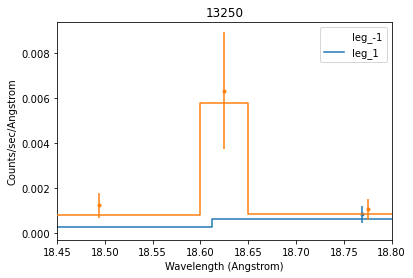

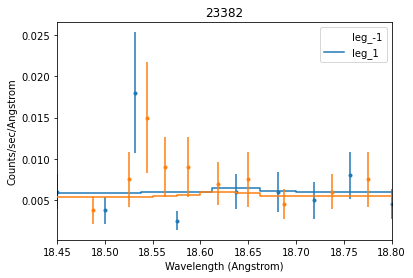

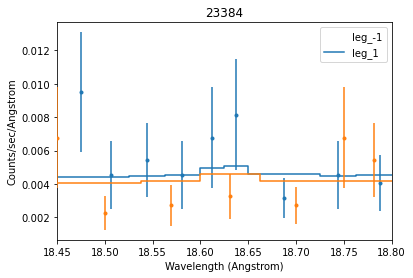

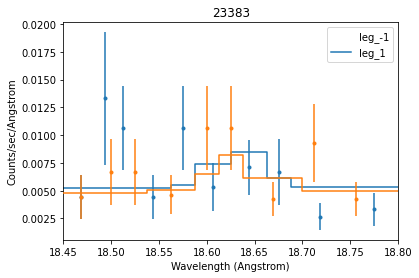

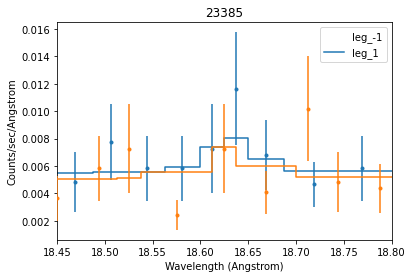

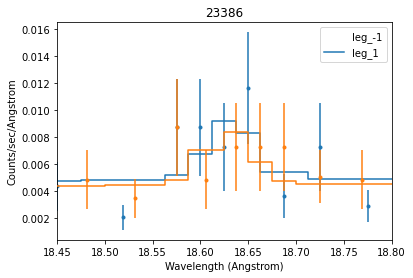

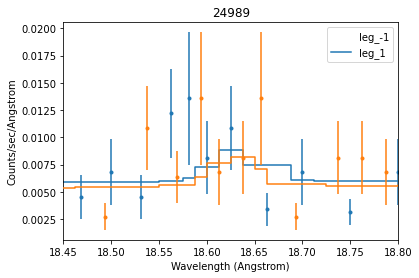

In [85]:
plot([18.45, 18.80], ['XMM_R1'])

In [86]:
farr2 = np.stack([np.array([c.parvals, c.parmins, c.parmaxes], 
                          dtype=np.floating) for c in conf_res_heb.values()])

farr2.shape

(14, 3, 2)

In [87]:
alpha2beta = farr[:, 0, 1] / farr2[:, 0, 1]
sig_alpha2beta = np.sqrt((farr[:, 2, 1] / farr2[:, 0, 1])**2 + (farr[:, 0, 1] * farr2[:, 2, 1] / farr2[:, 0, 1]**2)**2)

<ErrorbarContainer object of 3 artists>

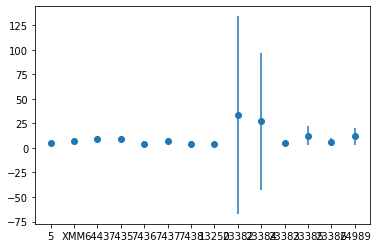

In [88]:
plt.errorbar(obsids, alpha2beta, yerr=sig_alpha2beta, fmt='o')

In [89]:
f2i = farr[:, 0, 3] / farr[:, 0, 2]
sig_f2i = np.sqrt((farr[:, 2, 3] / farr[:, 0, 2])**2 + (farr[:, 0, 3] * farr[:, 2, 2] / farr[:, 0, 2]**2)**2)

In [90]:
fi2r = (farr[:, 0, 3] + farr[:, 0, 2]) / farr[:, 0, 1]
sig_fi2r = np.sqrt((farr[:, 2, 3] / farr[:, 0, 1])**2 + 
                   (farr[:, 2, 2] / farr[:, 0, 1])**2 + 
                   ((farr[:, 0, 3] + farr[:, 0, 2]) * farr[:, 2, 1] / farr[:, 0, 1]**2)**2)

<ErrorbarContainer object of 3 artists>

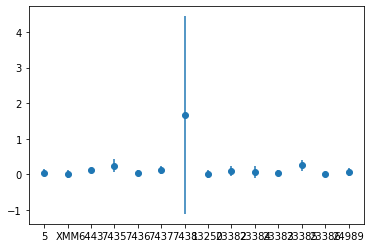

In [91]:
plt.errorbar(obsids, f2i, yerr=sig_f2i, fmt='o')

<ErrorbarContainer object of 3 artists>

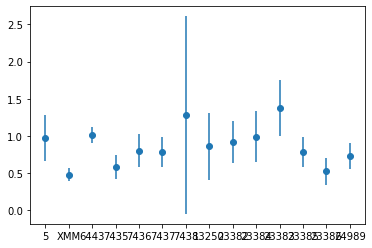

In [92]:
plt.errorbar(obsids, fi2r, yerr=sig_fi2r, fmt='o')

In [93]:
logtemp = np.arange(5.5, 7.01, .1)
temp = 10**logtemp
o7 = ch.ion('o_7', temperature=temp, eDensity=1.e+9, em=1.e+27)
o7.intensity()

In [95]:
e_heb = lineemiss(o7, ('lvl1', 1), ('pretty2', '1s.3p 1P1.0'))
e_hea = lineemiss(o7, ('lvl1', 1), ('pretty2', '1s.2p 1P1.0'))
e_i1 = lineemiss(o7, ('lvl1', 1), ('pretty2', '1s.2p 3P2.0'))
e_i2 = lineemiss(o7, ('lvl1', 1), ('pretty2', '1s.2p 3P1.0'))
e_f = lineemiss(o7, ('lvl1', 1), ('pretty2', '1s.2s 3S1.0'))

Text(0, 0.5, 'ratio Ly$\\alpha$/Ly$\\beta$')

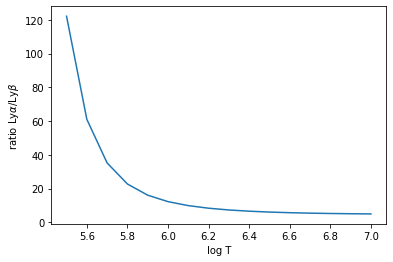

In [96]:
plt.plot(logtemp, e_hea / e_heb)
plt.xlabel('log T')
plt.ylabel('ratio Ly$\\alpha$/Ly$\\beta$')

Text(0, 0.5, 'ratio (f+i)/r')

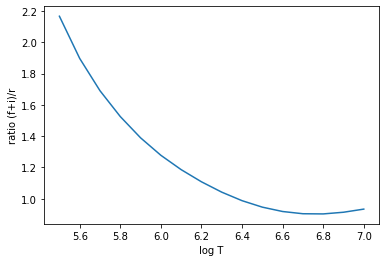

In [97]:
plt.plot(logtemp, (e_i1 + e_i2 + e_f) / e_hea)
plt.xlabel('log T')
plt.ylabel('ratio (f+i)/r')

In [98]:
xp = (e_i1 + e_f) / e_hea
sortind = np.argsort(xp)
xp = xp[sortind]
fp = logtemp[sortind]
t_from_g = np.interp(fi2r, xp, fp)
t_from_g_up = np.interp(fi2r + sig_fi2r, xp, fp) - t_from_g
t_from_g_do = np.interp(fi2r - sig_fi2r, xp, fp) - t_from_g

In [99]:
phabs = ui.xsphabs("phabs")
phabs.nH = .1

In [100]:
# Input is "edge of bins", return values are for bin center.
# So need to make a few narrow bins around the range I care.
absval = phabs(([21.7, 21.6, 21.5, 18.7, 18.6, 18.5, 5.]
                * u.Angstrom).to(u.keV, equivalencies=u.spectral()).value)
absval

array([0.43503806, 0.43934605, 0.49997282, 0.56844515, 0.5729878 ,
       0.74873716, 0.        ], dtype=float32)

In [101]:
abscoeffalpha = - 1e-21 * np.log(absval[2])
abscoeffbeta = - 1e-21 * np.log(absval[4])
abscoeffalpha, abscoeffbeta

(6.932015419006347e-22, 5.56890845298767e-22)

In [102]:
Gratio, Habobs = np.mgrid[.3:2:.01, 1:20:.01]

In [103]:
logT_from_G = np.interp(Gratio, xp, fp)
Hab_from_logT = np.interp(logT_from_G, logtemp, e_hea / e_heb)

N_H = np.log(Habobs/Hab_from_logT) / (abscoeffbeta - abscoeffalpha) / 1e21

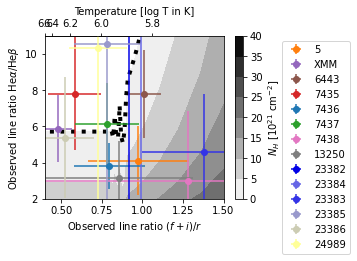

In [104]:

def grat2logt(g):
    return np.interp(g, xp, fp)

def logt2grat(logt):
    return np.interp(logt, fp[::-1], xp[::-1])

fig, ax = plt.subplots(figsize=(4,3))
cs = ax.contourf(Gratio, Habobs, np.ma.masked_less_equal(N_H, 0), cmap='binary')
cslines = ax.contour(Gratio, Habobs, N_H, levels=[0], linestyles=['dotted'], 
                     colors=['k'], linewidths=[4])
#ax.clabel(cs, cs.levels, inline=True, fontsize=10)
cb = fig.colorbar(cs, ax=ax)
for i, o in enumerate(obsids):
    eb = ax.errorbar(fi2r[i], alpha2beta[i] * 18.6 / 21.6, xerr=sig_fi2r[i], yerr=sig_alpha2beta[i],
                     fmt='o', label=o, color=obscolors[o])

secax = ax.secondary_xaxis('top', functions=(grat2logt, logt2grat))
secax.set_xlabel('Temperature [log T in K]')
    
ax.set_xlim(.4, 1.5)
ax.set_ylim(2, 11)
cb.set_label('$N_H$ [$10^{21}$ cm$^{-2}$]')
ax.set_xlabel('Observed line ratio $(f+i)/r$')
ax.set_ylabel('Observed line ratio He$\\alpha$/He$\\beta$')
ax.legend(loc='upper left', bbox_to_anchor=(1.3, 1))

fig.savefig('../plots/O-var.png', bbox_inches='tight', dpi=300)

## Global model

In [124]:
def apecmodel(prefix=''):
    abs1 = ui.xsphabs(name=f'{prefix}_abs1')
    abs1.nH = 0.1
    abs2 = ui.xsphabs(name=f'{prefix}_abs2')
    abs2.nH = 0.02  
    v1 = ui.xsvapec(name=f'{prefix}_v1')
    v2 = ui.xsvapec(name=f'{prefix}_v2')
    v3 = ui.xsvapec(name=f'{prefix}_v3')
    for v in [v2, v3]:
        for p in v1.pars[1:-2]:
            setattr(v, p.name, p)
    v1.kT = 0.25
    v1.kT.frozen = True
    v2.kT = .9
    v2.kT.frozen = True
    v3.kT = 5.
    v3.kT.frozen = True
    v1.Ne.frozen = False
    v1.Fe.frozen = False
    v1.Ne = 4
    v1.Ne.frozen = True
    v1.Fe = .3
    v1.Fe.frozen = True
    return abs1 * v1 + abs2 * (v2 + v3)

In [125]:
apecmodel()

<BinaryOpModel model instance '((xsphabs._abs1 * xsvapec._v1) + (xsphabs._abs2 * (xsvapec._v2 + xsvapec._v3)))'>

In [126]:
for obsid, ds in dslist.items():
    ds.set_source(apecmodel(prefix=obsid))

In [127]:
def fastfit(wvl, xmm=['XMM_R2']):
    for obsid, ds in dslist.items():
        ds.group_counts(10)
        ds.ignore(None, wvl[0])
        ds.ignore(wvl[1], None)
        ds.notice(*wvl)
        ui.set_stat("chi2gehrels")
        ui.set_method("levmar")
        if obsid == 'XMM':
            ui.fit(*xmm)
        else:
            ds.fit() 

In [128]:
fastfit([5., 25.])

Datasets              = '5_heg_-1', '5_heg_1', '5_meg_-1', '5_meg_1'
Method                = levmar
Statistic             = chi2gehrels
Initial fit statistic = 471.288
Final fit statistic   = 417.51 at function evaluation 337
Data points           = 410
Degrees of freedom    = 405
Probability [Q-value] = 0.323299
Reduced statistic     = 1.03089
Change in statistic   = 53.7779
   5_abs1.nH      0.0957961    +/- 0.029501    
   5_v1.norm      0.00157575   +/- 0.000204139 
   5_abs2.nH      0            +/- 0.0398097   
   5_v2.norm      0.000481287  +/- 7.65767e-05 
   5_v3.norm      0.00108255   +/- 7.31384e-05 
Dataset               = XMM_R2
Method                = levmar
Statistic             = chi2gehrels
Initial fit statistic = 5.40216e+10
Final fit statistic   = 530.786 at function evaluation 503
Data points           = 207
Degrees of freedom    = 202
Probability [Q-value] = 2.31236e-31
Reduced statistic     = 2.62765
Change in statistic   = 5.40216e+10
   XMM_abs1.nH    0.275206  

Datasets              = '23382_leg_-1', '23382_leg_1'
Method                = levmar
Statistic             = chi2gehrels
Initial fit statistic = 1081.24
Final fit statistic   = 979.557 at function evaluation 386
Data points           = 590
Degrees of freedom    = 585
Probability [Q-value] = 2.18558e-22
Reduced statistic     = 1.67446
Change in statistic   = 101.685
   23382_abs1.nH   0.163186     +/- 0.0478072   
   23382_v1.norm   0.00216131   +/- 0.000476131 
   23382_abs2.nH   5.6123e-05   +/- 0.0157121   
   23382_v2.norm   0.000901758  +/- 0.000226927 
   23382_v3.norm   0.0152799    +/- 0.000600164 
Datasets              = '23384_leg_-1', '23384_leg_1'
Method                = levmar
Statistic             = chi2gehrels
Initial fit statistic = 1117.94
Final fit statistic   = 848.639 at function evaluation 359
Data points           = 547
Degrees of freedom    = 542
Probability [Q-value] = 6.43253e-16
Reduced statistic     = 1.56576
Change in statistic   = 269.301
   23384_abs1.nH   

In [133]:
# Usually parse confres, but did not run conf yet, need a faster way
mymod = ui.get_model(dslist['5'].ids[0])

In [140]:
mymod

<RSPModelPHA model instance 'apply_rmf(apply_arf((47696.490944906 * ((xsphabs.5_abs1 * xsvapec.5_v1) + (xsphabs.5_abs2 * (xsvapec.5_v2 + xsvapec.5_v3))))))'>

In [143]:
for o in obsids:
    mymod = ui.get_model(dslist[o].ids[0])
    print(mymod.pars[0].val)

0.09579614210383597
0.27520604505129087
0.2168539104394494
0.05173207287051837
0.1270761525047609
0.05662935670345913
0.03301931320907397
0.2740111983980544
0.16318640515896918
0.1549392310005413
0.17411276901189243
0.16835989018643538
0.14348555645532882
0.15623412575179849


In [145]:
nh1 = np.array([ui.get_model(dslist[o].ids[0]).pars[0].val for o in obsids])
norm1 = np.array([ui.get_model(dslist[o].ids[0]).pars[16].val for o in obsids])
nh2 = np.array([ui.get_model(dslist[o].ids[0]).pars[17].val for o in obsids])
norm2 = np.array([ui.get_model(dslist[o].ids[0]).pars[33].val for o in obsids])
norm3 = np.array([ui.get_model(dslist[o].ids[0]).pars[-1].val for o in obsids])

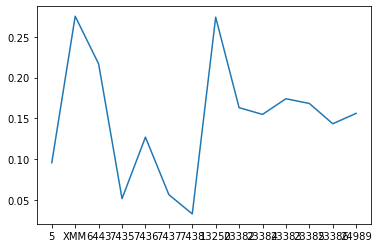

In [147]:
plt.plot(obsids, nh1)

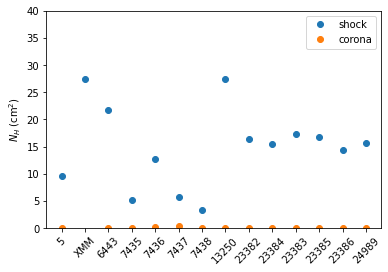

In [160]:
fig, ax = plt.subplots()
ax.errorbar(obsids, nh1 * 100, fmt='o', label='shock')
ax.errorbar(obsids, nh2 * 100, fmt='o', label='corona')
ax.legend()
ax.set_ylabel('$N_H\;(\mathrm{cm}^2$)')
ax.xaxis.set_tick_params(rotation=45)
# XMM fit went wrong
ax.set_ylim(0, 40)
fig.savefig('figures/NH.png', bbox_inches='tight', dpi=300)

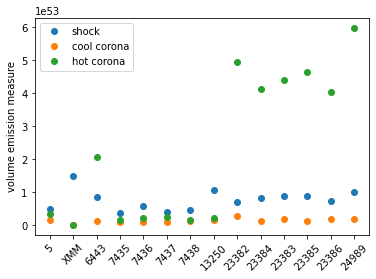

In [154]:
import astropy.units as u
fig, ax = plt.subplots()
fac = 1e14 * (52 * u.pc.to(u.cm))**2 * 4 * np.pi
ax.errorbar(obsids, norm1 * fac, fmt='o', label='shock')
ax.errorbar(obsids, norm2 * fac, fmt='o', label='cool corona')
ax.errorbar(obsids, norm3 * fac, fmt='o', label='hot corona')
ax.xaxis.set_tick_params(rotation=45)
ax.legend()
ax.set_ylabel('volume emission measure')
fig.savefig('figures/VEM.png', bbox_inches='tight', dpi=300)

# Notes
- XMM coords for R1 must be wrong - line is offset too far - > reduce RGS data by hand
- Chandra HEGT/HRC-I data is missing
- O VII and code is a dublication on Ne IX: Can I refactor more?
- Should I decouple fitting an ananylsis, similar to Dave etc al.? Put fits in scripts, run in eparate dirs to allow hand-tune individual fits without re-running everything? That's what I wanted to do with filili. Revisit?
- Ne IX and O VII plot look reversed to each other (red, green, pink crosses are mirrored). IS that physics or am I just lookign at a point cloud?
- Density plot should have right axis, or better background spiterweb with temp, dens (because ratio is also dependent on density somewhat). 
- Improve error estimates using MCMC instead of error propagation. Should also allow priors like "ignore negative N_H region". Some code for that is below, that's not integrated yet. (It's for a different notebook, that I accidentially workedo n separately and that I'm not removing to avoid confusing myself in the future).
- This probes "peak of GofT", so different O VII components are not weighted equally, but those at T near peak are strongest weightied. Check from of GofT for all lines to make sure they are similar. If they are, that's a matter for the discussion section, if they are not, it's a caveat (I don't really havea good idea what to do about it. Maybe the Hegamma lines are visible? THey would provide greater leverage in terms of A_V).

In [ ]:
def fit_triplet_MCMC(obsid, model):
    oids = get_dataids_obsid(obsid)
    for o in oids:
        set_source(o, model)
        set_stat("cash")
    fit(*oids)
    covar(*oids)
    stats, accept, params = get_draws(id=oids[0], otherids=oids[1:], niter=1e4)
    return params

## Reprocess LETGS data in 30 ks chunks so see how many counts we can expect for proposal

See https://cxc.cfa.harvard.edu/cal/Letg/LetgHrcEEFRAC/index.html for how to improve the S/N somewhat with non-standard settings. For the proposal I don't need that, fur a publication it might be worthwhile to explore the difference.

*Note* I don't see changes between chunks, but the wavelength is slightly off (need to fix 0-order location by hand), so I just got the count number from the total 150 ks and devided by five for the proposal.

In [ ]:
# The cells below take a long time to run, so I want ot make sure the notebook stops here.
raise Exception

In [ ]:
import ciao_contrib.runtool as rt

In [ ]:
# Everything could be done with CIAO tools, but I know astropy better, so I migh just as well use that
from astropy.io import fits
from astropy.table import Table

In [ ]:
# From the header for ObsID 6443
# I'm running this on an old computer, thus I don't want to open a large file just to get those two numbers
# when I'm running the notebook again.
TSTART = 272620141.4059900045
TSTOP = 272774659.6507499814

In [ ]:
for i in range(5):
    rt.dmcopy.punlearn()
    rt.dmcopy(infile='data/Chandra/6443/repro/hrcf06443_repro_evt2.fits[EVENTS][time={}:{}]'.format(TSTART + i * delta_t,
                                                                                                    TSTART + (i+1) * delta_t),
              outfile='data/Chandra/6443/repro/evt2_{}'.format(i), option="")
    rt.dmappend(infile='data/Chandra/6443/repro/hrcf06443_repro_evt2.fits[region][subspace -time]',
                outfile='data/Chandra/6443/repro/evt2_{}'.format(i))


In [ ]:
# Assuming DTCOR ppreviously calculated (i.e. for the entire exposure) is OK here, too.
# See https://cxc.cfa.harvard.edu/ciao/threads/spectra_letghrcs/ for how to redo that calculation.
# Not needed for proposal, because effect is in the percent range.

In [ ]:
for i in range(5):
    rt.tgextract.punlearn()
    rt.tgextract(infile='data/Chandra/6443/repro/evt2_{}'.format(i),
                 outfile='data/Chandra/6443/repro/pha2_{}'.format(i),
                 inregion_file='CALDB')

In [ ]:
path = 'data/Chandra/tgcat/obs_6443_tgid_2459/'

for i in range(5):
    ui.load_data('data/Chandra/6443/repro/pha2_{}'.format(i))
    for sign, sherpaid in zip(['-', ''], [1, 2]):
        for num in [1,2,3]:
            ui.load_arf(sherpaid, path+"leg_{}{}.arf.gz".format(sign, num), num)
            ui.load_rmf(sherpaid, path+"leg_{}{}.rmf.gz".format(sign, num), num)
        
    ui.copy_data(1, 't6443_{}_leg-1'.format(i))
    ui.copy_data(2, 't6443_{}_leg+1'.format(i))

In [ ]:
ui.set_analysis('wave')
ui.ignore(None, 13.40)
ui.ignore(13.75, None)
ui.notice(13.40, 13.75)

ui.plot_data('6443_leg-1')
for i in range(5):
    ui.plot_data('t6443_{}_leg-1'.format(i), overplot=True)

In [ ]:
ui.set_analysis('6443_leg-1', "energy", "counts", 0)

In [ ]:
ui.plot_data('6443_leg-1')

In [ ]:
pl = ui.get_data_plot('6443_leg-1')

In [ ]:
pl.y.sum()

In [ ]:
ui.set_analysis('wave')
#ui.ignore(None, 21.5)
#ui.ignore(22.3, None)
#ui.notice(21.5, 22.3)
ui.ignore(None, 13.40)
ui.ignore(13.75, None)
ui.notice(13.40, 13.75)
ui.set_analysis('6443_leg+1', "energy", "counts", 0)
pl = ui.get_data_plot('6443_leg+1')
ui.plot_data('6443_leg+1')
print(pl.y.sum())